# 1. Import library function and define custom functions

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import colors

import numpy as np
from scipy.optimize import curve_fit
from psana import *
import time

def Gaussian(x,a,b,c,d):
    return a*np.exp(-(x-b)**2/(2*c**2))+d

def Proj(img,ind1,ind2):
    return img[ind1:ind2,:].sum(0)

def PhotonSpectrumMoments(proj,hw):
    """Get the center, FWHM, AOC of the photon spectrum by direct calculation of first, second moments and array sum.
    Parameters
    ----------
    proj: photon spectrum, 1D array
    hw: predefined half width of the region centerd around spectrum peak
    Returns
    -------
    center, width and area of the photon spectrum
    
    """             
    x_max = proj.argmax()    
    
    inda = max(0,x_max-hw)
    indb = min(x_max+hw,img.shape[1]-1)
    ym = np.mean(proj[0:min(50,inda)])
    
    x = np.arange(inda,indb)                                
    y = proj[inda:indb]-ym
    y[y<0] = 0
    
    m1 = np.average(x,weights=y)
    m2 = np.sqrt(np.average((x-m1)**2,weights=y))
    
    return m1,m2,np.sum(y)

def PhotonSpectrumGauss(proj,hw):
    """Calcualte the center, FWHM, AOC of the photon spectrum by fitting with a Gaussian
    Parameters
    ----------
    proj: photon spectrum, 1D array
    hw: predefined half width of the region centerd around spectrum peak
    Returns
    -------
    center, FWHM, AOC of the photon spectrum
    
    """         
    x_max = proj.argmax()    
    
    inda = max(0,x_max-hw)
    indb = min(x_max+hw,img.shape[1]-1)
    
    x = np.arange(inda,indb)                                
    y = proj[inda:indb]
    
    p,q=curve_fit(Gaussian,x,y,p0=[proj[x_max],x_max,hw/2,np.mean(proj[0:min(20,inda)])])
    
    return p[1],2.355*np.abs(p[2]),np.sqrt(2*np.pi)*np.abs(p[2])*p[0]

def plot2d(mat,bins1,bins2,vmin=None,vmax=None,log10=True,cmap='seismic',ticks=None,xlabel=None,ylabel=None,title=None,rot=True):#'seismic'):#'RdBu_r':#'viridis'):
    """Plot 2d matrix
    Parameters
    ----------
    mat: matrix to be plotted
    bins1: bins along the x axis
    bins2: bins along the y axis
    vmin: minimum of the color scale
    vmax: maximum of the color scale
    log10: use log scale or not
    cmap: choice of cmap
    ticks: if it is None, use default tikcs, if is a tick array, use it as the ticks on the colorbar
    Returns
    -------
    plotted image handle
    
    """        
    mat = mat.copy()
    mat = np.ma.array(mat, mask=np.isnan(mat))
    if not vmin:
        vmin = mat[~np.isnan(mat)].min()
    if not vmax:
        vmax = mat[~np.isnan(mat)].max()        
        
    if rot:
        mat = np.rot90(mat)
    if log10:


        im=plt.imshow(mat,extent=[bins1.min(),bins1.max(),bins2.min(),bins2.max()],
                   aspect='auto',cmap=cmap,norm=colors.SymLogNorm(linthresh=1, linscale=1,
                                                                  vmin=vmin, vmax=vmax, clip=False))
    else:
        im=plt.imshow(mat,extent=[bins1.min(),bins1.max(),bins2.min(),bins2.max()],
                   aspect='auto',cmap=cmap,vmin=vmin,vmax=vmax)  
#     try:
#         if ticks:
#             plt.colorbar(im,ticks=np.concatenate(ticks))
#         else:
#             plt.colorbar(im)
#     except Exception as e:
#         print(e)
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
    if title:
        plt.title(title)        
    
    return im

## 2. Define experiment, run and analysis parameters

In [2]:
exp = 'tmox45419'
runnum=23
ds = DataSource(exp=exp,run=runnum)
run = next(ds.runs())
opal = run.Detector('tmo_opal2')
mevt = 1000
ind1,ind2,hw = 450,500,100

## 3-1. Analysis method I - Calculate the first and second moment of the 1D array

In [10]:
m1s = np.zeros(mevt);m2s = np.zeros(mevt);areas = np.zeros(mevt)
t1 = time.time()
for nevt,evt in enumerate(run.events()):
    if nevt>=mevt:
        break 
    img = opal.raw.image(evt)
    proj = Proj(img,ind1,ind2) 
    """
    The following lines until the end of this cell should be bench marked by the MHz testing
    """
    m1,m2,area = PhotonSpectrumMoments(proj,hw)
    m1s[nevt] = m1
    m2s[nevt] = m2
    areas[nevt] = area 
t2 = time.time()
print('Processing time:',t2-t1)

Processing time: 7.23956298828125


## 3-2. Analysis method II - Calculate the center and FWHM of fitted functions (Gaussian)

In [13]:
m1s_g = np.zeros(mevt);m2s_g = np.zeros(mevt);areas_g = np.zeros(mevt)
t1 = time.time()
for nevt,evt in enumerate(run.events()):
    if nevt>=mevt:
        break 
    img = opal.raw.image(evt)
    proj = Proj(img,ind1,ind2)    
    """
    The following lines until the end of this cell should be bench marked by the MHz testing
    """    
    try:
        m1_g,m2_g,area_g = PhotonSpectrumGauss(proj,hw)
    except Exception as e:
        m1_g,m2_g,area_g = np.nan,np.nan,np.nan
    m1s_g[nevt] = m1_g
    m2s_g[nevt] = m2_g
    areas_g[nevt] = area_g    
t2 = time.time()
print('Processing time:',t2-t1)

Processing time: 9.571329355239868


## Appendix

In [5]:
det_xgmd = run.Detector('xgmd')
det_ebm = run.Detector('ebeam')

m1s = np.zeros(mevt);m2s = np.zeros(mevt);areas = np.zeros(mevt)
m1s_g = np.zeros(mevt);m2s_g = np.zeros(mevt);areas_g = np.zeros(mevt)
xgmds = np.zeros(mevt);ebms = np.zeros(mevt)
for nevt,evt in enumerate(run.events()):
    if nevt>=mevt:
        break 
    img = opal.raw.image(evt)
    proj = Proj(img,ind1,ind2)
    
    xgmd = det_xgmd.raw.energy(evt)
    ebm_l3 = det_ebm.raw.ebeamL3Energy(evt)  
    xgmds[nevt] = xgmd
    ebms[nevt] = ebm_l3
    m1,m2,area = PhotonSpectrumMoments(proj,hw)
    m1s[nevt] = m1
    m2s[nevt] = m2
    areas[nevt] = area
    try:
        m1_g,m2_g,area_g = PhotonSpectrumGauss(proj,hw)
    except Exception as e:
        print(nevt, e)
        m1_g,m2_g,area_g = np.nan,np.nan,np.nan
    m1s_g[nevt] = m1_g
    m2s_g[nevt] = m2_g
    areas_g[nevt] = area_g    
 

<IPython.core.display.Javascript object>


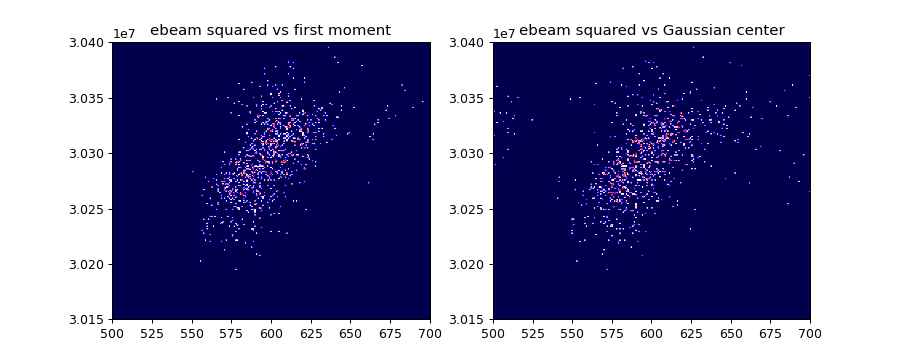

Text(0.5, 1.0, 'ebeam squared vs Gaussian center')

In [7]:
bins_m1 = np.linspace(500,700,200)
bins_ebm2 = np.linspace(3.015e7,3.04e7,200)
plt.figure(figsize=(10,4))
plt.subplot(121)
m1_ebm,_,_ = np.histogram2d(m1s,ebms**2,bins=[bins_m1,bins_ebm2])
plot2d(m1_ebm,bins_m1,bins_ebm2)
plt.title('ebeam squared vs first moment')
plt.subplot(122)
m1_ebm,_,_ = np.histogram2d(m1s_g,ebms**2,bins=[bins_m1,bins_ebm2])
plot2d(m1_ebm,bins_m1,bins_ebm2)
plt.title('ebeam squared vs Gaussian center')


<IPython.core.display.Javascript object>


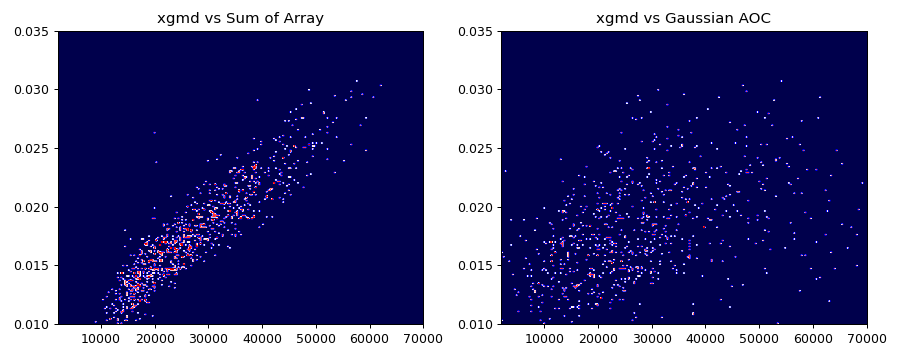

In [8]:
bins_area = np.linspace(2000,7e4,200)
bins_xgmd = np.linspace(0.01,0.035,200)
plt.figure(figsize=(10,4))
plt.subplot(121)
area_xgmd,_,_ = np.histogram2d(areas,xgmds,bins=[bins_area,bins_xgmd])
plot2d(area_xgmd,bins_area,bins_xgmd)
plt.title('xgmd vs Sum of Array')
plt.subplot(122)
area_xgmd,_,_ = np.histogram2d(areas_g,xgmds,bins=[bins_area,bins_xgmd])
plot2d(area_xgmd,bins_area,bins_xgmd)
plt.title('xgmd vs Gaussian AOC')
plt.tight_layout()